In [147]:
# import libraries for data manipulation
import numpy as np
import pandas as pd

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# disable pop_up display of graphs to display them in notebook.
%matplotlib inline

In [148]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
!wget $data

--2025-09-29 15:42:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.2’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.07s   

2025-09-29 15:42:56 (11.2 MB/s) - ‘car_fuel_efficiency.csv.2’ saved [874188/874188]



In [149]:
df = pd.read_csv("car_fuel_efficiency.csv")

In [150]:
df.shape

(9704, 11)

## Data Preparation

In [151]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df_lr = df[cols].copy()

df_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   horsepower           8996 non-null   float64
 2   vehicle_weight       9704 non-null   float64
 3   model_year           9704 non-null   int64  
 4   fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 379.2 KB


## EDA

### Question 0
Look at the `fuel_efficiency_mpg` variable. Does it have a long tail? 
- No, it looks ~ normally distributed.

<Axes: title={'center': 'Fuel Efficiency in MPG'}, xlabel='fuel_efficiency_mpg', ylabel='frequency'>

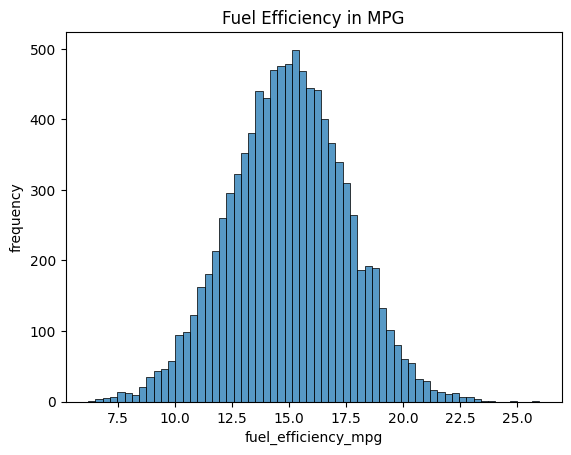

In [152]:
plt.title('Fuel Efficiency in MPG')
plt.ylabel('frequency')
sns.histplot(data=df_lr, x='fuel_efficiency_mpg')

### Question 1
There's one column with missing values. What is it?
- Horsepower

In [153]:
df_lr.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

### Question 2
What's the median (50% percentile) for variable `'horsepower'`?
- 149

In [154]:
df_lr['horsepower'].describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

## Prepare and split the dataset

In [174]:
def split(df, seed=42):
    # set split sizes
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)

    # generate a sequence of numbers that represents our indices
    idx = np.arange(n)
    # shuffle the indices
    np.random.seed(seed) # ensures same shuffle everytime
    np.random.shuffle(idx)

    # split the data
    df_train = df_lr.iloc[idx[n_train:]]
    df_val = df_lr.iloc[idx[n_train:(n_val + n_train)]]
    df_test = df_lr.iloc[idx[(n_val + n_train):]]

    # reset the indices
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_test, df_val

In [156]:
def get_target(train, test, val, y):
    # get the target vector
    y_train = train[y].values
    y_test = test[y].values
    y_val = val[y].values

    return y_train, y_test, y_val


## Train and Validation Methods

In [157]:
def train_linear_reg(X, y):
    '''Train linear regression to get bias term and weight vector.'''
    # add bias term col to X
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # calculate weight vector (normal equation)
    XTX = X.T.dot(X) # gram matrix
    XTX_inverse = np.linalg.inv(XTX) # inverse of the gram matrix
    w_full = XTX_inverse.dot(X.T).dot(y) # weight vector of X

    # get bias term, and remove from w
    w_0 = w_full[0]
    w = w_full[1:]

    return w_0, w

In [158]:
def rmse(y, y_pred):
	'''Calculate Root Mean Squared Error for Model Validation.'''
	error = y - y_pred
	sqr_error = error ** 2
	mse = sqr_error.mean()
	
	return np.sqrt(mse)
    

## Feature Engineering

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`

Which option gives better RMSE?
* with mean

In [175]:
df_train, df_test, df_val = split(df_lr)
y_train, y_test, y_val = get_target(df_train, df_test, df_val, y='fuel_efficiency_mpg')

# remove target vector from dataset
del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
# Handle missing vals in horsepower
# training
train_zero = df_train.fillna({'horsepower': 0})
train_mean = df_train.fillna({'horsepower': df_train['horsepower'].mean()})

#validation
val_zero = df_val.fillna({'horsepower': 0})
val_mean = df_val.fillna({'horsepower': df_train['horsepower'].mean()})

In [176]:
# missing filled with zero
zero_w_0, zero_w = train_linear_reg(train_zero, y_train)
zero_y_pred = zero_w_0 + train_zero.dot(zero_w)

zero_val_y_pred = zero_w_0 + val_zero.dot(zero_w)

print(f"Train RMSE w/ 0 in missing vals: {rmse(y_train, zero_y_pred):.2f}")
print(f"Validation RMSE w/ 0 in missing vals: {rmse(y_val, zero_val_y_pred):.2f}")

Train RMSE w/ 0 in missing vals: 0.52
Validation RMSE w/ 0 in missing vals: 0.52


In [161]:
# missing filled with mean
mean_w_0, mean_w = train_linear_reg(train_mean, y_train)
mean_y_pred = mean_w_0 + train_mean.dot(mean_w)

mean_val_y_pred = mean_w_0 + val_mean.dot(mean_w)

print(f"Train RMSE w/ mean in missing vals: {rmse(y_train, mean_y_pred):.2f}")
print(f"Validation RMSE w/ mean in missing vals: {rmse(y_val, mean_val_y_pred):.2f}")

Train RMSE w/ mean in missing vals: 0.46
Validation RMSE w/ mean in missing vals: 0.46


## Model Improvement 

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.
* r_value: 0
* w_0: 25.76
* w: [ 3.60622916e-05, 3.69826771e-03, -5.01362264e-03, 1.86542140e-03]
* train RMSE: 0.52
* validation RMSE: 0.52

In [162]:
def train_linear_regression_reg(X, y, r=0.0):
    '''Train linear regression to get bias term and weight vector w/ Regularization'''
    # add bias term col to X
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # calculate weight vector (normal equation)
    XTX = X.T.dot(X) # gram matrix
    # apply regularization
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inverse = np.linalg.inv(XTX) # inverse of the gram matrix
    w_full = XTX_inverse.dot(X.T).dot(y) # weight vector of X

    # get bias term, and remove from w
    w_0 = w_full[0]
    w = w_full[1:]

    return w_0, w

In [163]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_values:
    w_0, w = train_linear_regression_reg(train_zero, y_train, r=r)
    y_pred = w_0 + train_zero.dot(w)
    
    y_pred_val = w_0 + val_zero.dot(w)

    print("-----------------------")
    print(f"r_value: {r}\nw_0: {w_0:.2f}\nw: {w}")
    print(f"train RMSE: {rmse(y_train, y_pred):.2f}")
    print(f"validation RMSE: {rmse(y_val, y_pred_val):.2f}")

    

-----------------------
r_value: 0
w_0: 25.76
w: [ 3.60622916e-05  3.69826771e-03 -5.01362264e-03  1.86542140e-03]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 0.01
w_0: 20.84
w: [ 3.00503812e-05  3.70093014e-03 -5.01301968e-03  4.31327480e-03]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 0.1
w_0: 7.66
w: [ 1.39629632e-05  3.70805460e-03 -5.01140619e-03  1.08635496e-02]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 1
w_0: 1.05
w: [ 5.88887923e-06  3.71163008e-03 -5.01059637e-03  1.41511087e-02]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 5
w_0: 0.22
w: [ 4.87667649e-06  3.71207741e-03 -5.01049467e-03  1.45634973e-02]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 10
w_0: 0.11
w: [ 4.74604913e-06  3.71213410e-03 -5.01048136e-03  1.46170005e-02]
train RMSE: 0.52
validation RMSE: 0.52
-----------------------
r_value: 100
w_0: 0.01
w: [ 4.64081439e-06  3.7121

## Random Seed Testing

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 

What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`. Round the result to 3 decimal digits (`round(std, 3)`)
* my_answer: $0.007$
* selected_answer: $0.006$

In [167]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RMSEs = []

for s in seeds:
    df_train, df_test, df_val = split(df_lr, seed=s)
    y_train, y_test, y_val = get_target(df_train, df_test, df_val, y='fuel_efficiency_mpg')

    # remove target vector from dataset
    del df_train['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']

    # Handle missing vals in horsepower
    train_zero = df_train.fillna({'horsepower': 0})
    w_0, w = train_linear_reg(train_zero, y_train)

    val_zero = df_val.fillna({'horsepower': 0})
    y_pred_val = w_0 + val_zero.dot(w)

    val_RMSE = rmse(y_val, y_pred_val)

    print(f"seed: {s}, RMSE: {val_RMSE:.2f}")

    RMSEs.append(val_RMSE)

RMSE_std = np.std(RMSEs)

round(RMSE_std, 3)
    

seed: 0, RMSE: 0.52
seed: 1, RMSE: 0.52
seed: 2, RMSE: 0.52
seed: 3, RMSE: 0.52
seed: 4, RMSE: 0.51
seed: 5, RMSE: 0.53
seed: 6, RMSE: 0.53
seed: 7, RMSE: 0.51
seed: 8, RMSE: 0.51
seed: 9, RMSE: 0.51


np.float64(0.007)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 

What's the RMSE on the test dataset?
* 0.515

In [181]:
df_train, df_test, df_val = split(df_lr, seed=9)
y_train, y_test, y_val = get_target(df_train, df_test, df_val, y='fuel_efficiency_mpg')

# remove target vector from dataset
del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

# Handle missing vals in horsepower
train_zero = df_train.fillna({'horsepower': 0})
val_zero = df_val.fillna({'horsepower': 0})
zero = pd.concat([train_zero, val_zero], axis=0)
y = pd.concat([pd.Series(y_train), pd.Series(y_val)])

w_0, w = train_linear_regression_reg(zero, y, r=0.001)

y_pred = w_0 + zero.dot(w)

print(f"RMSE: {rmse(y, y_pred):.2f}")



RMSE: 0.51
